In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer, WordNetLemmatizer
import re
import warnings
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.under_sampling import RandomUnderSampler
from tqdm import tqdm
import multiprocessing
warnings.filterwarnings('ignore')

In [2]:
# Initialize Stemming and Lemmatization
stemmer = LancasterStemmer()
lemmatizer = WordNetLemmatizer()

In [3]:
# Load spaCy model
try:
    nlp = spacy.load('en_core_web_sm', disable=['ner'])
except:
    import os
    os.system('python -m spacy download en_core_web_sm')
    nlp = spacy.load('en_core_web_sm', disable=['ner'])

In [4]:
# Defining a basic stopword list
stopwords_list = set([
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves',
    'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their',
    'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was',
    'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
    'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between',
    'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off',
    'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any',
    'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than',
    'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now'
])

In [5]:
# Loading dataset
try:
    train_data = pd.read_csv('C:/Users/Sanjana Shah/AV GenAI Certification/NLP_Pytorch/Assignment/training.1600000.processed.noemoticon.csv', delimiter=',', encoding='ISO-8859-1')
except Exception as e:
    print(f"Error loading dataset: {e}")

In [6]:
# Adding meaningful column names
train_data.columns = ['Sentiment','Tweet_ID','Date','Query','User','Text']

In [7]:
# Handling duplicates and missing data
train_data.drop_duplicates(subset=['Text'], inplace=True)
train_data.dropna(subset=['Text'], inplace=True)

In [8]:
# Text cleaning and preprocessing functions

def clean_text(text):
    text = re.sub(r'<.*?>', '', str(text))
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [9]:
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stopwords_list]
    return ' '.join(filtered_words)

In [10]:
def preprocess_text(text, use_stemming=False):
    text = clean_text(text)
    text = text.lower()
    text = remove_stopwords(text)
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    if use_stemming:
        tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(tokens)

In [11]:
def batch_preprocess_text(texts, use_stemming=False):
    processed_texts = []
    for doc in nlp.pipe(texts, batch_size=1000, disable=['ner']):
        tokens = [token.lemma_ for token in doc if not token.is_stop]
        if use_stemming:
            tokens = [stemmer.stem(token) for token in tokens]
        processed_texts.append(' '.join(tokens))
    return processed_texts

In [12]:
# Applying Preprocessing in Batches
batch_size = 10000
filtered_texts = []

for i in tqdm(range(0, len(train_data), batch_size), desc="Processing Batches"):
    batch_texts = train_data['Text'].iloc[i:i+batch_size].tolist()
    filtered_texts.extend(batch_preprocess_text(batch_texts, use_stemming=True))

train_data['Filtered_Text'] = filtered_texts

Processing Batches: 100%|████████████████████████████████████████████████████████████| 104/104 [23:51<00:00, 13.76s/it]


In [13]:
# Mapping sentiments
sentiment_mapping = {0: "Negative", 2: "Neutral", 4: "Positive"}
train_data['Sentiment_Label'] = train_data['Sentiment'].map(sentiment_mapping)
train_data.dropna(inplace=True)

In [19]:
X = train_data['Filtered_Text']
y = train_data['Sentiment_Label']

# Handling class imbalance using RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(X), y)
X_resampled = X_resampled.squeeze()

In [20]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Vectorizing the text using TF-IDF
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [27]:
# Models (With Cross-Validation Added)
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, n_jobs=-1),
    'Naive Bayes': MultinomialNB(),
    }

results = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name} with Cross-Validation...")
    # Cross-Validation
    cv_scores = cross_val_score(model, X_train_vectorized, y_train, cv=3, scoring='f1_weighted')
    print(f"{model_name} Cross-Validation F1 Score: {np.mean(cv_scores)}")

    # Training the model
    model.fit(X_train_vectorized, y_train)

    # Predictions
    y_pred = model.predict(X_test_vectorized)

    # Performance metrics
    results[model_name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1-Score': f1_score(y_test, y_pred, average='weighted')
    }


Training Logistic Regression with Cross-Validation...
Logistic Regression Cross-Validation F1 Score: 0.7614895566836913

Training Naive Bayes with Cross-Validation...
Naive Bayes Cross-Validation F1 Score: 0.7486469225040078


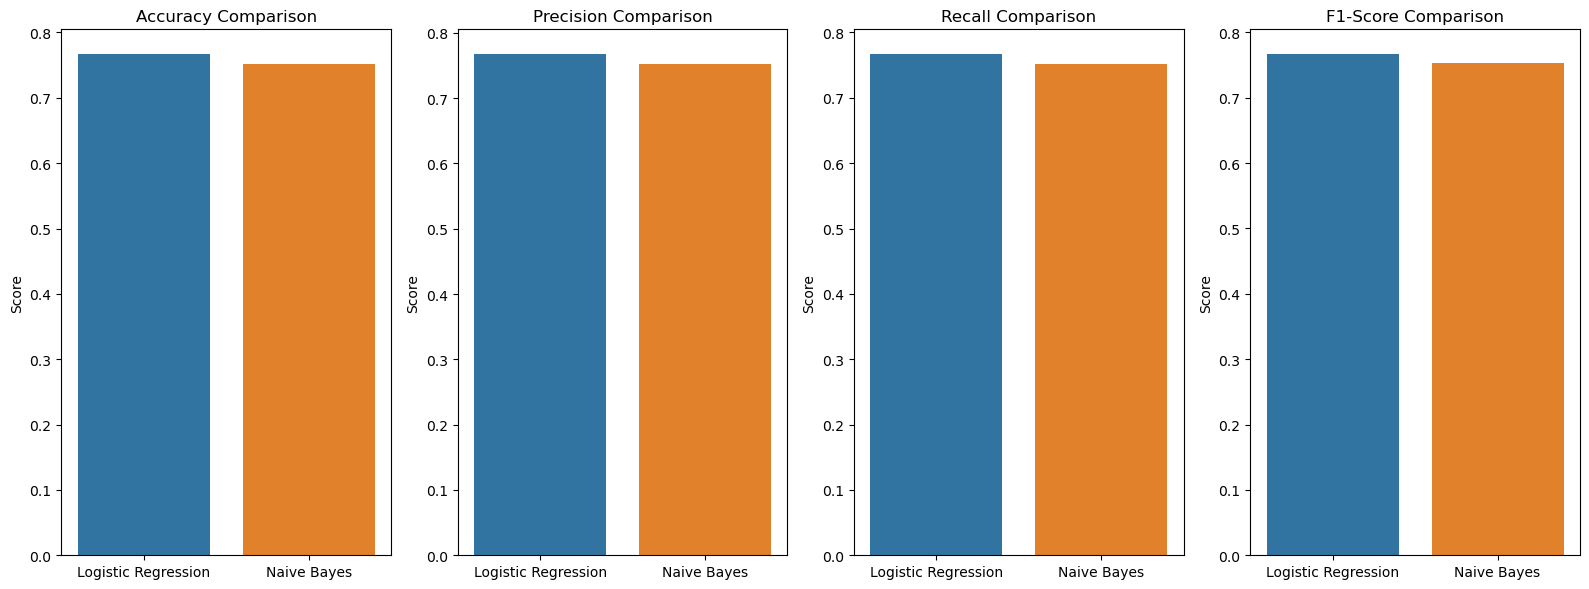

In [28]:
# Plotting results
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
plt.figure(figsize=(16, 6))
for i, metric in enumerate(metrics):
    plt.subplot(1, 4, i+1)
    sns.barplot(x=list(results.keys()), y=[results[model][metric] for model in results])
    plt.title(f'{metric} Comparison')
    plt.ylabel('Score')
plt.tight_layout()
plt.show()

In [29]:
# Displaying results
results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison with Cross-Validation:")
print(results_df)


Model Performance Comparison with Cross-Validation:
                     Accuracy  Precision    Recall  F1-Score
Logistic Regression  0.766510   0.767037  0.766510  0.766399
Naive Bayes          0.752523   0.752536  0.752523  0.752521
